Making this a part 3, since Andrej made things hard with having the label there
but (I think) didn't say anything about removing it, but on the Github 
it's not there lol

In [7]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

the labelling scheme really screws everything up so I'm going to get rid of it
in the actual documentation on Github, there is no label function, 
so I think it's best to just scrap it, make a copy, and start over
my actual draw_dot(n(x)) isn't even accurate at this point anyway

In [92]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f'Value(data={self.data})'

    # addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # back propogation specifically for the addition
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # negation, which will be used for subtraction
    def __neg__(self):
        return self * -1
    
    # subtraction--the addition of the negation of something else
    def __sub__(self, other):
        return self + (-other)
    
    # multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # back propogation specifically for multiplication
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    # anything raised to any power by the power rule
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only suppporting ints and floats for now'
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other*self.data**(other-1)) * out.grad
            
        out._backward = _backward
        return out
    
    # true division for the constant k = -1 in (a/b) = a*b**-1
    def __truediv__(self, other):
        return self * other**-1
    
    # since python doesn't know the difference b/n e.g. 2 * a and a * 2
    # need a rescue function that'll save a failure from happening by reversing
    # order of multiplication
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)
    
    # temporary activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            # local derivative of e^x was just calculated for out
            # multiply this by out.grad for chen lu
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
    
    # backpropogation to be performed given neuron connections
    def backward(self):
        # first need to topologicall sort connected neurons
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        # build the topological sort to prepare for backpropogation
        build_topo(self)

        # now we want the back propogation to happen after the sort
        self.grad = 1.0 # since gradient of last neuron will be 1
        for node in reversed(topo):
            # will call whatever backprop method is needed from other methods
            node._backward()

In [82]:
from graphviz import Digraph

def trace(root):
    # construct graph with nodes and connected edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for every value in the graph, create a node for it
        dot.node(name = uid, label='{data = %.2f | grad %.2f}' % (n.data, n.grad), shape='record')
        
        # if the current node is an operation, create a node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

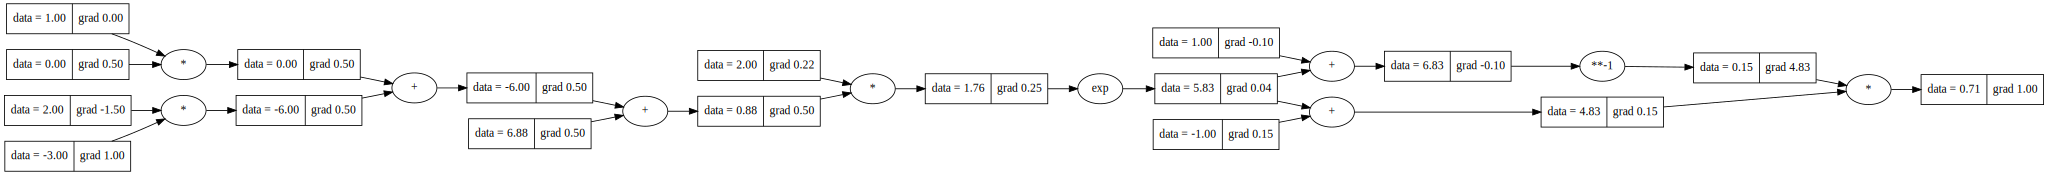

In [83]:
# instantiate inputs
x1 = Value(2.0)
x2 = Value(0.0)

# instantiate weights
w1 = Value(-3.0)
w2 = Value(1.0)

# bias of the neuron
b = Value(6.8813735870195432)

# now add things together 
x1w1 = x1*w1; 
x2w2 = x2*w2; 

x1w1x2w2 = x1w1 + x2w2; 
n = x1w1x2w2 + b; 

# redefining o in terms of our new exponential function
e = (2*n).exp()
o = (e - 1) / (e + 1); 
o.backward()
draw_dot(o)

Now, we're going to be building up to the multilayer perceptron

In [132]:
class Neuron:
    # constructor function
    # takes in number of inputs: nin
    # weights are randomly initialized, and assigned with the number of inputs there are
    # bias is also initialized to be some random number
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1.0, 1.0)) for _ in range(nin)]
        self.b = Value(random.uniform(-1.0, 1.0))
        
    # call function -- allows you to use an object's method as if it were a function
    def __call__(self, x):
        # we want sum(wi * xi) + b for all of the weights and inputs
        # eventually to feed into activation function    
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    # we want a way to be able to access the parameters of the network
    # define this in order to act like PyTorch and call for them
    def parameters(self):
        return self.w + [self.b]
    

# to make a layer of neurons, specify how many inputs + outputs there are
class Layer:
    def __init__(self, nin, nout):
        # layer of neurons is literally a list of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        # outputs will be the activated neuron signals from the layer of neurons
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    # let's call the parameters for the layer itself using list comprehension
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    
# now we're making a layer of layers -- a multilayer perceptron (MLP)
class MLP:
    # nin is the number of inputs
    # nouts specifies the number of neurons that there will be 
    # ex. [4, 4, 1] specifies four neurons in second and third layers, and one neuron serves as the output layer
    # of the MLP
    def __init__(self, nin, nouts):
        # size of the MLP, basically specifies neuron geometry
        sz = [nin] + nouts 
        # construct layers by (number of neurons, number of outconnecting neurons)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        # iterates through all of the layers in order to obtain an output
        for layer in self.layers:
            x = layer(x)
        return x
    
    # be able to call parameters of the MLP like how PyTorch does
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [133]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.42453310751400963)

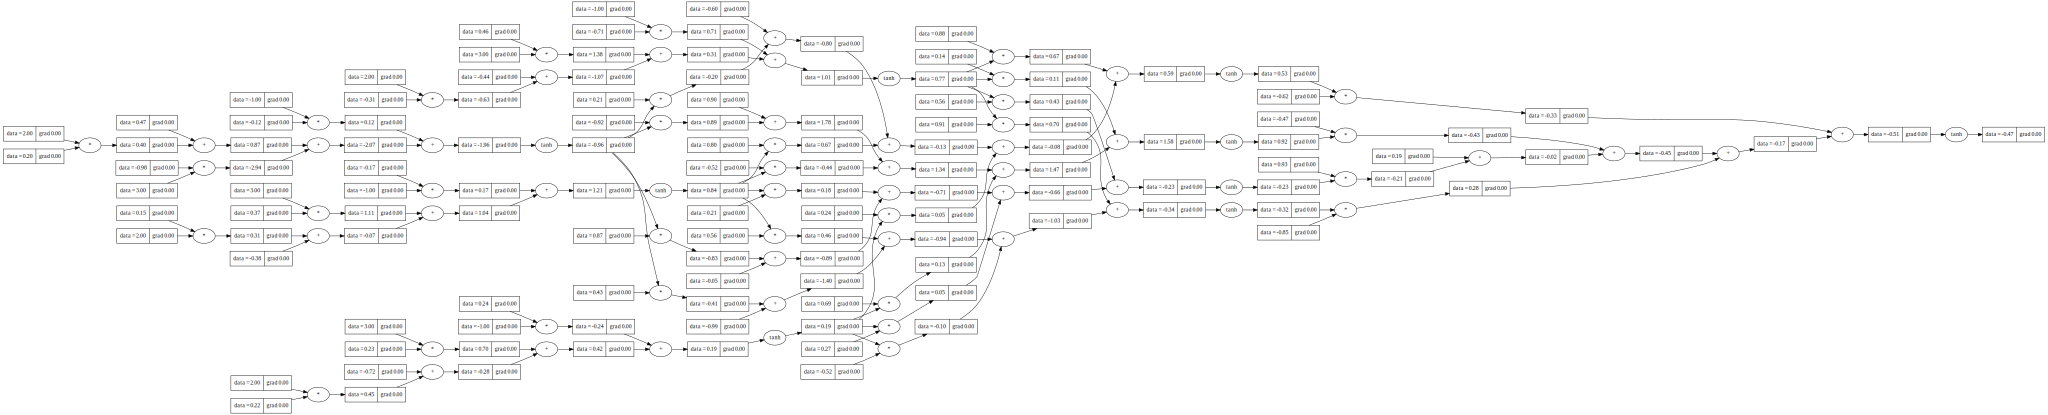

In [126]:
draw_dot(n(x))

Now let's do a simpler example

In [127]:
# define input data set
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# specify how our neural net should classify these inputs
# these are the targets of the neural network, they are the desired Bayseian posterior (?)
# given any of the list of inputs, we want the output to match with the element of each target
ys = [1.0, -1.0, -1.0, 1.0]
# let's just test out what the neural network will output, regardless of how we want to adjust the weights
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.4663949180387415),
 Value(data=0.9326355019248421),
 Value(data=0.45414483927920457),
 Value(data=0.2198475175401055)]

In [128]:
# define the loss function, which characterizes how far away the neural networks predictions are
# to the ground truth
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=8.608569148440814)

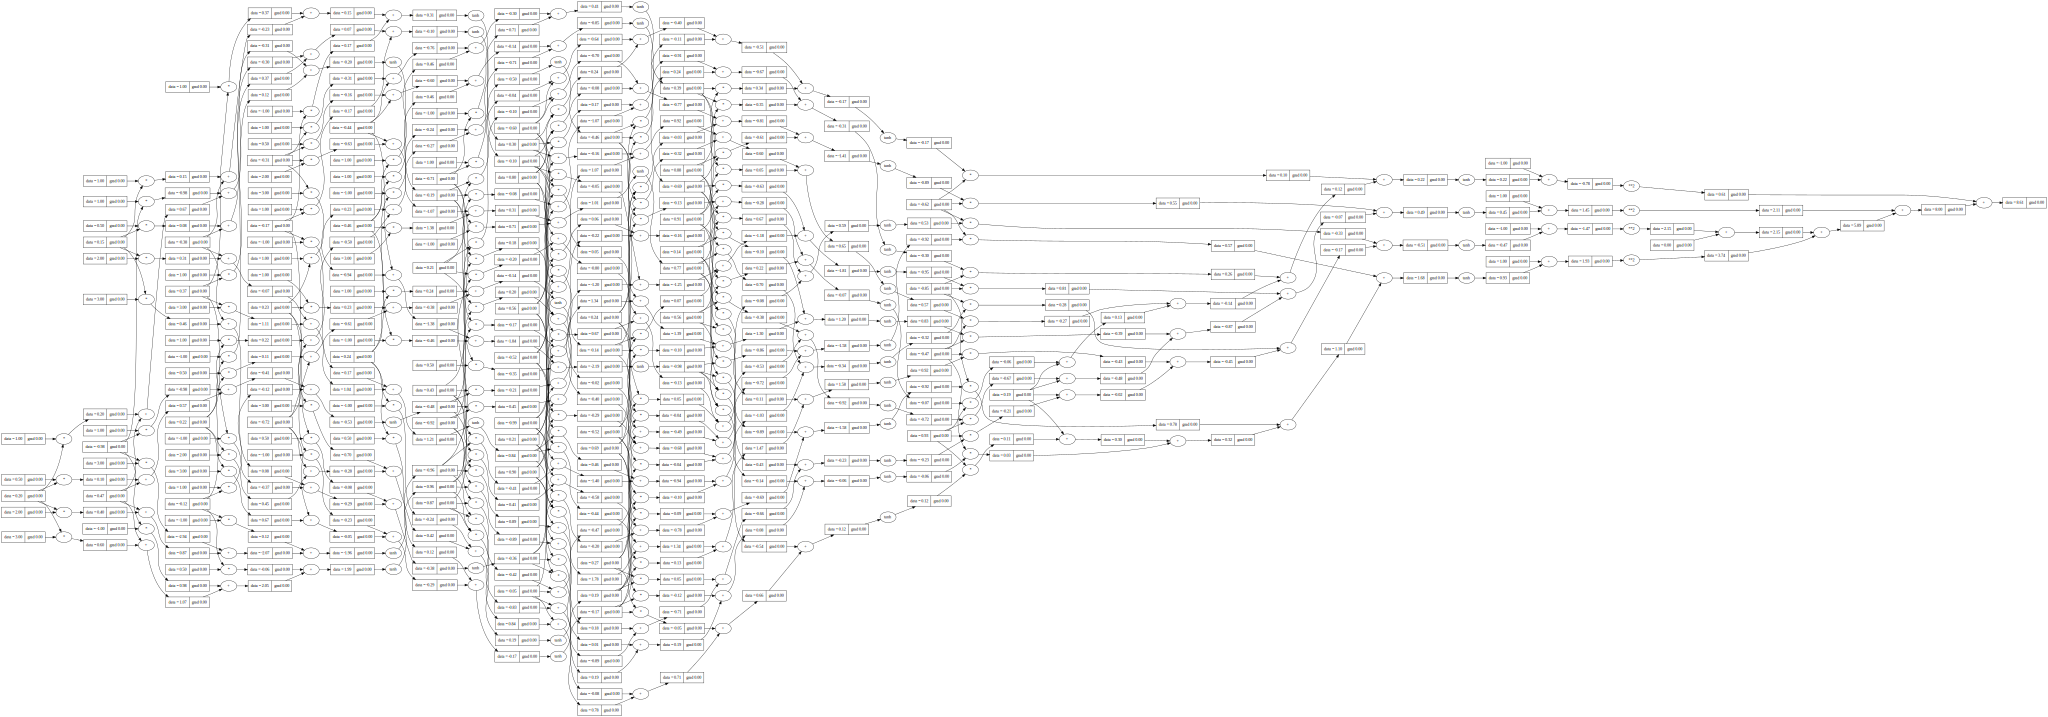

In [129]:
# huge! yuge!
draw_dot(loss)

In [130]:
# now let's do back propogation on the loss as we understand how to minimize the loss
loss.backward()

In [131]:
n.layers[0].neurons[0].w[0].grad

-0.5278017893161109